# (03) Shattering dim

**Motivation**: Accuracy in all possible pairwise categorization of MNIST digits. 5 digits per category. <br>

In [1]:
# HIDE CODE


import os, sys
from IPython.display import display

# tmp & extras dir
git_dir = os.path.join(os.environ['HOME'], 'Dropbox/git')
extras_dir = os.path.join(git_dir, 'jb-vase/_extras')
fig_base_dir = os.path.join(git_dir, 'jb-vae/figs')
tmp_dir = os.path.join(git_dir, 'jb-vae/tmp')

# GitHub
sys.path.insert(0, os.path.join(git_dir, '_PoissonVAE'))
from analysis.eval import sparse_score
from figures.fighelper import *
from vae.train_vae import *

# warnings, tqdm, & style
warnings.filterwarnings('ignore', category=DeprecationWarning)
from rich.jupyter import print
%matplotlib inline
set_style()

In [2]:
device_idx = 0
device = f'cuda:{device_idx}'

In [3]:
from analysis.shatter import (
    shatter_analysis,
    disjoint_groups,
    digit2category
)

## Experiment: LogReg vs. SVM vs. KNN

### Load trainer

In [4]:
name = '/'.join([
    'poisson_uniform_c(-3)_rmax(1)_MNIST_z-10_k-32_<conv+b|conv+b>',
    'initscale-0.05_warmrestart-2_mc_b200-ep1200-lr(0.002)_beta(1:0x0.5)_temp(0.05:lin-0.5)_gr(1000)_(2024_05_01,17:07)',
])
tr, meta = load_quick(name, device=device, lite=False)
data, loss, etc = tr.validate()

loss_avg = {k: v.mean() for k, v in loss.items()}
loss_avg['tot'] = loss_avg['kl'] + loss_avg['mse']
print(loss_avg, '\n', meta)

{'mse': 27.612318, 'kl': 8.89106, 'kl_diag': 0.8891061, 'tot': 36.50338}


{
    'timestamp': '2024_05_01,17:07',
    'checkpoint': 1200,
    'global_step': 360000,
    'root': 
'/home/hadi/Projects/PoissonVAE/models/poisson_uniform_c(-3)_rmax(1)_MNIST_z-10_k-32_<conv+b|conv+b>/initscale-0.05
_warmrestart-2_mc_b200-ep1200-lr(0.002)_beta(1:0x0.5)_temp(0.05:lin-0.5)_gr(1000)_(2024_05_01,17:07)',
    'file': 'PoissonVAE+TrainerVAE-1200_(2024_05_01,22:04).pt'
}

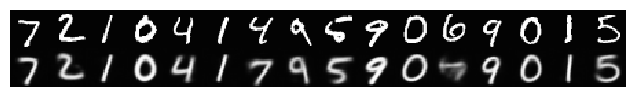

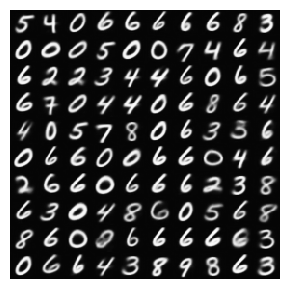

In [5]:
tr.show_recon(0.0), tr.show_samples(0.0);

### Xtract data

In [6]:
%%time

t = 0.0

data, loss, etc = {}, {}, {}
for k in ['trn', 'vld']:
    data[k], loss[k], etc[k] = tr.forward(
        dl_name=k, temp=t, full_data=True)
loss_avg = {
    name: {k: v.mean() for k, v in d.items()}
    for name, d in loss.items()
}

CPU times: user 15.2 s, sys: 348 ms, total: 15.6 s
Wall time: 3.25 s


### Disjoint grouping of digits

In [7]:
digits = tonp(tr.dl_trn.dataset.tensors[1]).astype(int)
groups = disjoint_groups(sorted(np.unique(digits)))
len(groups)

252

### Classify

In [8]:
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report

In [9]:
kws = dict(
    C=1.0,
    penalty='l2',
    random_state=0,
)

df = []
for clf_name in ['logreg', 'svm', 'knn']:
    for c0, c1 in tqdm(groups, desc=clf_name, ncols=80):
        y = digit2category(data['trn']['g'], c1)
        y_vld = digit2category(data['vld']['g'], c1)
        if clf_name == 'logreg':
            clf = LogisticRegression(**kws)
        elif clf_name == 'svm':
            clf = LinearSVC(dual='auto', **kws)
        elif clf_name == 'knn':
            clf = KNeighborsClassifier()
        else:
            raise NotImplementedError(clf_name)

        clf.fit(etc['trn']['log_dr'], y)
        pred = clf.predict(etc['vld']['log_dr'])
    
        report = classification_report(
            y_true=y_vld,
            y_pred=pred,
            output_dict=True,
        )
        df.append({
            'category_0': [c0],
            'category_1': [c1],
            'classifier': [type(clf).__name__],
            'accuracy': [report['accuracy']],
            'type': [tr.model.cfg.type],
        })

df = pd.DataFrame(merge_dicts(df))

knn: 100%|████████████████████████████████████| 252/252 [02:13<00:00,  1.89it/s]


In [10]:
df

,category_0,category_1,classifier,accuracy,type
0,"[0, 1, 2, 3, 4]","[5, 6, 7, 8, 9]",LogisticRegression,0.7013,poisson
1,"[0, 1, 2, 3, 5]","[4, 6, 7, 8, 9]",LogisticRegression,0.8461,poisson
2,"[0, 1, 2, 3, 6]","[4, 5, 7, 8, 9]",LogisticRegression,0.8733,poisson
3,"[0, 1, 2, 3, 7]","[4, 5, 6, 8, 9]",LogisticRegression,0.8612,poisson
4,"[0, 1, 2, 3, 8]","[4, 5, 6, 7, 9]",LogisticRegression,0.8659,poisson
...,...,...,...,...,...
751,"[4, 5, 6, 7, 9]","[0, 1, 2, 3, 8]",KNeighborsClassifier,0.9834,poisson
752,"[4, 5, 6, 8, 9]","[0, 1, 2, 3, 7]",KNeighborsClassifier,0.9807,poisson
753,"[4, 5, 7, 8, 9]","[0, 1, 2, 3, 6]",KNeighborsClassifier,0.9824,poisson
754,"[4, 6, 7, 8, 9]","[0, 1, 2, 3, 5]",KNeighborsClassifier,0.9842,poisson


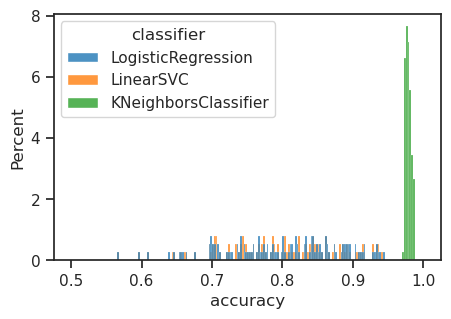

In [15]:
sns.histplot(
    data=df,
    x='accuracy',
    hue='classifier',
    stat='percent',
    bins=np.linspace(0.5, 1, 201),
    alpha=0.8,
);

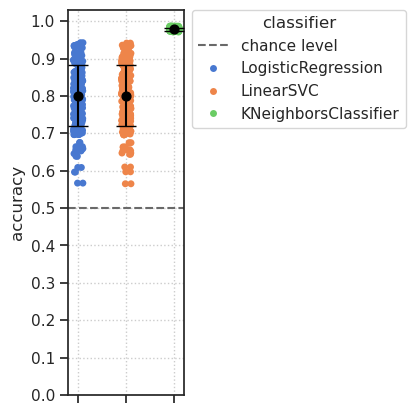

In [16]:
fig, ax = create_figure(1, 1, (1.5, 5))


ax.axhline(0.5, ls='--', color='dimgrey', label='chance level')

classifiers = list(df['classifier'].drop_duplicates())

sns.stripplot(
    data=df,
    x='classifier',
    y='accuracy',
    hue='classifier',
    order=classifiers,
    palette='muted',
    legend=True,
    ax=ax
)
move_legend(ax, (1, 1.02))
ax.set(xticklabels=[], xlabel='', ylim=(0, 1.03))
ax.locator_params(axis='y', nbins=11)
ax.grid()

mu = df.groupby('classifier')['accuracy'].mean()
sd = df.groupby('classifier')['accuracy'].std()
se = sd / df.groupby('classifier').size() ** 0.5

for i, clf in enumerate(classifiers):
    ax.scatter(i, mu[clf], color='k', s=40, zorder=4)
    ax.errorbar(i, mu[clf], yerr=sd[clf], fmt='none', color='black', capsize=7, zorder=3)

# Show plot
plt.show()

# plt.show()

### Overall accuracy

10-way classification

In [17]:
# LinearSVC
clf = LinearSVC(dual='auto').fit(
    X=etc['trn']['log_dr'], 
    y=data['trn']['g'].astype(int),
)
report = classification_report(
    y_true=data['vld']['g'].astype(int),
    y_pred=clf.predict(etc['vld']['log_dr']),
    output_dict=True,
)
print(f"{type(clf).__name__} ——— accuracy: {report['accuracy']}")


# LogisticRegression
clf = LogisticRegression().fit(
    X=etc['trn']['log_dr'], 
    y=data['trn']['g'].astype(int),
)
report = classification_report(
    y_true=data['vld']['g'].astype(int),
    y_pred=clf.predict(etc['vld']['log_dr']),
    output_dict=True,
)
print(f"{type(clf).__name__} ——— accuracy: {report['accuracy']}")


# KNeighborsClassifier
clf = KNeighborsClassifier().fit(
    X=etc['trn']['log_dr'], 
    y=data['trn']['g'].astype(int),
)
report = classification_report(
    y_true=data['vld']['g'].astype(int),
    y_pred=clf.predict(etc['vld']['log_dr']),
    output_dict=True,
)
print(f"{type(clf).__name__} ——— accuracy: {report['accuracy']}")

LinearSVC ——— accuracy: 0.9261

LogisticRegression ——— accuracy: 0.9417

KNeighborsClassifier ——— accuracy: 0.9613

## Shattering Dim

In [18]:
groups = disjoint_groups(range(10))
len(groups)

252

In [19]:
selected_models = {
    'poisson': '/'.join([
        'poisson_uniform_c(-3)_rmax(1)_MNIST_z-10_k-32_<conv+b|conv+b>',
        'initscale-0.05_warmrestart-2_mc_b200-ep1200-lr(0.002)_beta(1:0x0.5)_temp(0.05:lin-0.5)_gr(1000)_(2024_05_01,17:07)'
    ]),
    'gaussian': '/'.join([
        'gaussian_None_MNIST_z-10_k-32_<conv+b|conv+b>',
        'eps1.0-warm2_mc_b200-ep900-lr(0.002)_beta(1:0x0.5)_gr(1000)_(2024_05_02,08:38)',
    ]),
}

### Logistic Regression

poisson:
{'trn': {'mse': 27.381172, 'kl': 8.876027, 'kl_diag': 0.8876025}, 'vld': {'mse': 27.433294, 'kl': 8.89106, 
'kl_diag': 0.8891061}}

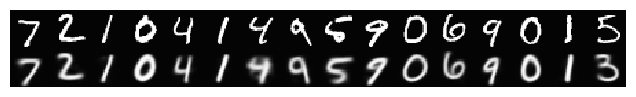

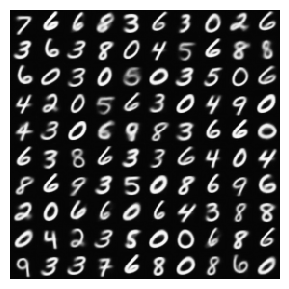

logreg: 252it [00:11, 21.59it/s]


gaussian:
{'trn': {'mse': 9.200378, 'kl': 13.181685, 'kl_diag': 1.3181688}, 'vld': {'mse': 11.519066, 'kl': 13.1146965, 
'kl_diag': 1.3114696}}

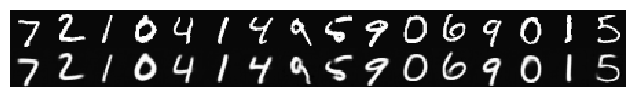

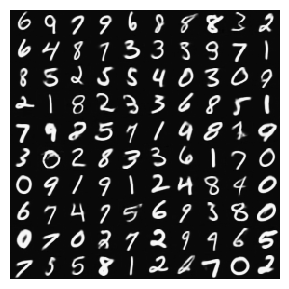

logreg: 252it [00:05, 43.43it/s]


In [20]:
df = []
for model_type, load_string in selected_models.items():
    tr, meta = load_quick(load_string, device=device, lite=False)
    t = 0.0 if model_type == 'poisson' else 1.0

    data, loss, etc = {}, {}, {}
    for k in ['trn', 'vld']:
        data[k], loss[k], etc[k] = tr.forward(
            dl_name=k, temp=t, full_data=True)
    loss_avg = {
        name: {k: v.mean() for k, v in d.items()}
        for name, d in loss.items()
    }
    print(f"{model_type}:\n{loss_avg}")
    tr.show_recon(t), tr.show_samples(t);

    # prep to fit
    key = 'log_dr' if model_type == 'poisson' else 'mu'
    x = {k: v[key] for k, v in etc.items()}
    labels = {k: v['g'] for k, v in data.items()}
    # fit
    _df = shatter_analysis(x, labels, groups, clf_type='logreg')
    _df.insert(3, 'type', tr.model.cfg.type)
    df.append(_df)
df = pd.concat(df)

In [21]:
df.groupby('type')['accuracy'].mean()

type
gaussian    0.762935
poisson     0.800558
Name: accuracy, dtype: float64

In [22]:
df.groupby('type')['accuracy'].std()

type
gaussian    0.061123
poisson     0.082196
Name: accuracy, dtype: float64

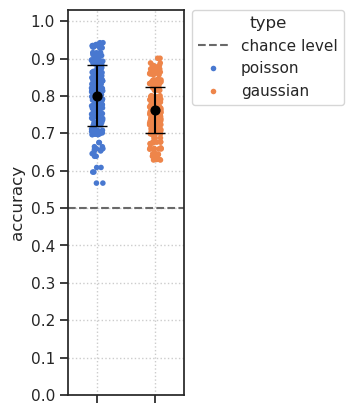

In [24]:
fig, ax = create_figure(1, 1, (1.5, 5))

ax.axhline(0.5, ls='--', color='dimgrey', label='chance level')

model_types = list(df['type'].drop_duplicates())

sns.stripplot(
    data=df,
    x='type',
    y='accuracy',
    hue='type',
    order=model_types,
    palette='muted',
    legend=True,
    size=4,
    ax=ax
)
move_legend(ax, (1, 1.02))
ax.set(xticklabels=[], xlabel='', ylim=(0, 1.03), xlim=(-0.5, 1.5))
ax.locator_params(axis='y', nbins=11)
ax.grid()

mu = df.groupby('type')['accuracy'].mean()
sd = df.groupby('type')['accuracy'].std()

for i, k in enumerate(model_types):
    ax.scatter(i, mu[k], color='k', s=40, zorder=4)
    ax.errorbar(i, mu[k], yerr=sd[k], fmt='none', color='black', capsize=7, zorder=3)

plt.show()

In [25]:
accuracies = df.groupby('type')['accuracy'].apply(list)
accuracies

type
gaussian    [0.6438, 0.7781, 0.758, 0.7747, 0.7886, 0.6387...
poisson     [0.7013, 0.8461, 0.8733, 0.8612, 0.8659, 0.742...
Name: accuracy, dtype: object

In [26]:
t_stat, p_value = sp_stats.ttest_ind(
    a=accuracies['poisson'],
    b=accuracies['gaussian'],
)
print(p_value)

9.89075561234778e-09

In [27]:
sorted_ids = df.groupby('type')['accuracy'].apply(list).apply(np.argsort).to_dict()
sorted_ids

{'gaussian': array([219,  32, 221,  30, 246,   5,   0, 251, 237,  14,  10, 241,  25,
        226,  52, 199, 205,  46,  60, 191, 229,  22, 130, 121,   6, 245,
        231,  20,  17, 234, 227,  24, 178,  73,  23, 228, 239,  12, 177,
        167,  84,  74,  21, 230, 170,  81, 236,  15, 107, 144,  72, 179,
         19, 232,  53, 198, 165,  86, 233, 242,  18,   9, 220,  31, 150,
        101, 137, 114, 143, 171, 108,  80,   8, 243, 164,  87, 195,  56,
        197,  48, 203,  54, 173,  78,  13, 238, 166,  85, 100, 151,  95,
        156,  49, 202, 240,  11,  35, 216, 213,  38, 142, 109, 211,  40,
        161,  90, 157,  94, 192,  59, 126, 125,  83, 168,  92, 159,  98,
        153,  26, 225,  70, 181,   2, 249, 214,  37,  97, 154, 204,  47,
        184,  67, 187,  64, 129, 122, 217,  34, 218,  33, 162,  89, 235,
         16,  88, 163, 111, 140,  93, 158, 134, 117, 208,  43,  58, 193,
        212,  39, 248,   3,   1, 250,  41, 210,  42, 209, 222,  29, 206,
         45, 155,  96,  36, 215, 103, 1

In [28]:
ids = np.concatenate([
    sorted_ids['poisson'][-3:],
    sorted_ids['poisson'][:3],
])
df.iloc[ids]

,group_idx,category_0,category_1,type,classifier,accuracy
136,136,"[1, 2, 3, 6, 8]","[0, 4, 5, 7, 9]",poisson,LogisticRegression,0.9377
149,149,"[1, 2, 4, 7, 9]","[0, 3, 5, 6, 8]",poisson,LogisticRegression,0.9425
102,102,"[0, 3, 5, 6, 8]","[1, 2, 4, 7, 9]",poisson,LogisticRegression,0.9425
52,52,"[0, 1, 6, 7, 8]","[2, 3, 4, 5, 9]",poisson,LogisticRegression,0.5669
199,199,"[2, 3, 4, 5, 9]","[0, 1, 6, 7, 8]",poisson,LogisticRegression,0.5669
24,24,"[0, 1, 3, 4, 8]","[2, 5, 6, 7, 9]",poisson,LogisticRegression,0.5964


In [29]:
ids = np.concatenate([
    sorted_ids['gaussian'][-3:],
    sorted_ids['gaussian'][:3],
])
df.iloc[ids]

,group_idx,category_0,category_1,type,classifier,accuracy
61,61,"[0, 2, 3, 5, 6]","[1, 4, 7, 8, 9]",poisson,LogisticRegression,0.9351
118,118,"[0, 4, 6, 7, 9]","[1, 2, 3, 5, 8]",poisson,LogisticRegression,0.9082
133,133,"[1, 2, 3, 5, 8]","[0, 4, 6, 7, 9]",poisson,LogisticRegression,0.9082
219,219,"[2, 4, 5, 7, 8]","[0, 1, 3, 6, 9]",poisson,LogisticRegression,0.6087
32,32,"[0, 1, 3, 6, 9]","[2, 4, 5, 7, 8]",poisson,LogisticRegression,0.6087
221,221,"[2, 4, 5, 8, 9]","[0, 1, 3, 6, 7]",poisson,LogisticRegression,0.6573


### SVM

poisson:
{'trn': {'mse': 27.381172, 'kl': 8.876027, 'kl_diag': 0.8876025}, 'vld': {'mse': 27.433294, 'kl': 8.89106, 
'kl_diag': 0.8891061}}

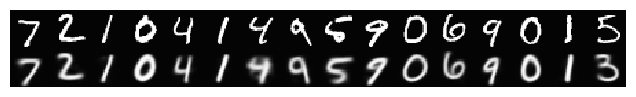

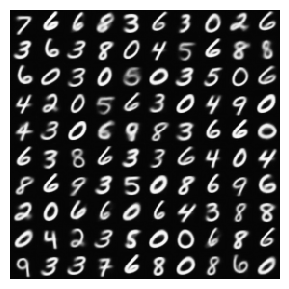

svm: 252it [00:15, 16.02it/s]


gaussian:
{'trn': {'mse': 9.200378, 'kl': 13.181685, 'kl_diag': 1.3181688}, 'vld': {'mse': 11.519066, 'kl': 13.1146965, 
'kl_diag': 1.3114696}}

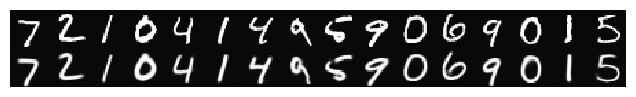

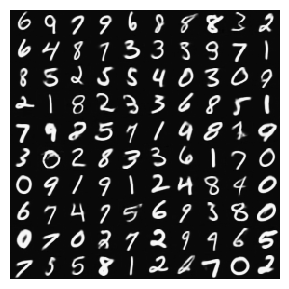

svm: 252it [00:07, 31.98it/s]


In [30]:
df = []
for model_type, load_string in selected_models.items():
    tr, meta = load_quick(load_string, device=device, lite=False)
    t = 0.0 if model_type == 'poisson' else 1.0

    data, loss, etc = {}, {}, {}
    for k in ['trn', 'vld']:
        data[k], loss[k], etc[k] = tr.forward(
            dl_name=k, temp=t, full_data=True)
    loss_avg = {
        name: {k: v.mean() for k, v in d.items()}
        for name, d in loss.items()
    }
    print(f"{model_type}:\n{loss_avg}")
    tr.show_recon(t), tr.show_samples(t);

    # prep to fit
    key = 'log_dr' if model_type == 'poisson' else 'mu'
    x = {k: v[key] for k, v in etc.items()}
    labels = {k: v['g'] for k, v in data.items()}
    # fit
    _df = shatter_analysis(x, labels, groups, clf_type='svm')
    _df.insert(3, 'type', tr.model.cfg.type)
    df.append(_df)
df = pd.concat(df)

In [31]:
df.groupby('type')['accuracy'].mean()

type
gaussian    0.762971
poisson     0.800638
Name: accuracy, dtype: float64

In [32]:
df.groupby('type')['accuracy'].std()

type
gaussian    0.061050
poisson     0.081627
Name: accuracy, dtype: float64

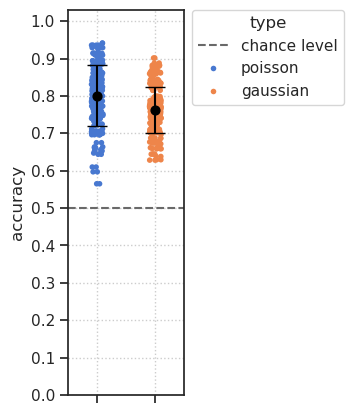

In [33]:
fig, ax = create_figure(1, 1, (1.5, 5))

ax.axhline(0.5, ls='--', color='dimgrey', label='chance level')

model_types = list(df['type'].drop_duplicates())

sns.stripplot(
    data=df,
    x='type',
    y='accuracy',
    hue='type',
    order=model_types,
    palette='muted',
    legend=True,
    size=4,
    ax=ax
)
move_legend(ax, (1, 1.02))
ax.set(xticklabels=[], xlabel='', ylim=(0, 1.03), xlim=(-0.5, 1.5))
ax.locator_params(axis='y', nbins=11)
ax.grid()

mu = df.groupby('type')['accuracy'].mean()
sd = df.groupby('type')['accuracy'].std()

for i, k in enumerate(model_types):
    ax.scatter(i, mu[k], color='k', s=40, zorder=4)
    ax.errorbar(i, mu[k], yerr=sd[k], fmt='none', color='black', capsize=7, zorder=3)

plt.show()

In [34]:
accuracies = df.groupby('type')['accuracy'].apply(list)
accuracies

type
gaussian    [0.6443, 0.7786, 0.7575, 0.7759, 0.7886, 0.638...
poisson     [0.7, 0.843, 0.8711, 0.8574, 0.8661, 0.74, 0.7...
Name: accuracy, dtype: object

In [35]:
t_stat, p_value = sp_stats.ttest_ind(
    a=accuracies['poisson'],
    b=accuracies['gaussian'],
)
print(p_value)

8.103069557708762e-09

In [36]:
sorted_ids = df.groupby('type')['accuracy'].apply(list).apply(np.argsort).to_dict()
sorted_ids

{'gaussian': array([219,  32, 221,  30, 246,   5,   0, 251,  14, 237,  10, 241,  25,
        226, 199,  52, 205,  46, 191,  60, 229,  22, 231,  20, 121, 130,
        245,   6,  17, 234,  24, 227,  73, 178,  23, 228, 239,  12,  84,
        167, 177,  74, 230,  21, 170,  81, 107, 144,  72, 179,  15, 236,
        232,  19, 198,  53, 165,  86,   9, 242, 233,  18, 220,  31, 150,
        101, 137, 114, 171,  80, 143, 108,   8, 243,  87, 164,  56, 195,
        197,  54,  78, 173, 166,  85,  48, 203, 151, 100, 238,  13, 202,
         49, 156,  95, 240,  11, 216,  35, 213,  38, 109, 142, 161,  90,
        211,  40, 192,  59,  94, 157, 126, 125,  83, 168,  98, 153,  92,
        159, 249,   2,  70, 181, 225,  26, 214,  37,  97, 154, 204,  47,
        184,  67, 187,  64, 129, 122, 218,  33, 158,  93, 217,  34,  16,
        235,  88, 163,  89, 162, 134,  58, 117, 193, 208,  43, 111, 140,
         39, 212, 248,   3, 250,   1,  41, 210,  42, 209,  29, 222,  45,
        206, 155,  96, 103, 148,   7, 2

In [37]:
ids = np.concatenate([
    sorted_ids['poisson'][-3:],
    sorted_ids['poisson'][:3],
])
df.iloc[ids]

,group_idx,category_0,category_1,type,classifier,accuracy
115,115,"[0, 4, 5, 7, 9]","[1, 2, 3, 6, 8]",poisson,LinearSVC,0.9359
102,102,"[0, 3, 5, 6, 8]","[1, 2, 4, 7, 9]",poisson,LinearSVC,0.9414
149,149,"[1, 2, 4, 7, 9]","[0, 3, 5, 6, 8]",poisson,LinearSVC,0.9414
52,52,"[0, 1, 6, 7, 8]","[2, 3, 4, 5, 9]",poisson,LinearSVC,0.5651
199,199,"[2, 3, 4, 5, 9]","[0, 1, 6, 7, 8]",poisson,LinearSVC,0.5651
227,227,"[2, 5, 6, 7, 9]","[0, 1, 3, 4, 8]",poisson,LinearSVC,0.5971


In [38]:
ids = np.concatenate([
    sorted_ids['gaussian'][-3:],
    sorted_ids['gaussian'][:3],
])
df.iloc[ids]

,group_idx,category_0,category_1,type,classifier,accuracy
61,61,"[0, 2, 3, 5, 6]","[1, 4, 7, 8, 9]",poisson,LinearSVC,0.9359
118,118,"[0, 4, 6, 7, 9]","[1, 2, 3, 5, 8]",poisson,LinearSVC,0.9103
133,133,"[1, 2, 3, 5, 8]","[0, 4, 6, 7, 9]",poisson,LinearSVC,0.9103
219,219,"[2, 4, 5, 7, 8]","[0, 1, 3, 6, 9]",poisson,LinearSVC,0.6099
32,32,"[0, 1, 3, 6, 9]","[2, 4, 5, 7, 8]",poisson,LinearSVC,0.6099
221,221,"[2, 4, 5, 8, 9]","[0, 1, 3, 6, 7]",poisson,LinearSVC,0.6564
